# CIFAR-10 Dataset: A Computer Vision Benchmark

## Overview
CIFAR-10 is a widely-used benchmark dataset in the field of computer vision and machine learning, specifically designed for object recognition tasks. Originally curated by researchers Alex Krizhevsky, Vinod Nair, and Geoffrey Hinton, it serves as a fundamental resource for developing and evaluating image classification algorithms.

## Dataset Specifications
- **Total Images**: 60,000 color images
- **Image Resolution**: 32x32 pixels
- **Format**: RGB color images
- **Split Distribution**:
  - Training set: 50,000 images (5,000 per class)
  - Testing set: 10,000 images (1,000 per class)

## Object Classes
The dataset contains exactly 10 distinct categories, with each image belonging to precisely one class:
1. Airplane
2. Automobile (excluding pickup trucks)
3. Bird
4. Cat
5. Deer
6. Dog
7. Frog
8. Horse
9. Ship
10. Truck (excluding pickup trucks)

## Dataset Origins
CIFAR-10 represents a carefully curated subset of the larger "80 million tiny images" dataset. Its manageable size and well-balanced class distribution make it particularly suitable for:
- Prototyping new computer vision algorithms
- Educational purposes in machine learning courses
- Benchmarking classification models
- Testing deep learning architectures

## Historical Significance
The dataset has become a standard benchmark in the machine learning community, helping researchers and practitioners evaluate and compare different approaches to image classification since its release.

Will Cukierski. CIFAR-10 - Object Recognition in Images. https://kaggle.com/competitions/cifar-10, 2013. Kaggle.

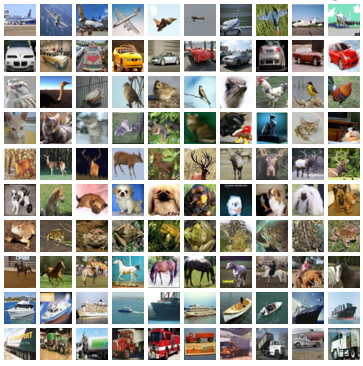


In [1]:
# Download with (x_train, y_train), (x_test, y_test) = cifar10.load_data() #was slow to download
# or 
# https://www.cs.toronto.edu/~kriz/cifar.html #as well was slow
# or 
# https://www.kaggle.com/competitions/cifar-10/data #faster, but filled with junk files in test (against cheating in the competition)

In [2]:
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow.keras.backend as K
import itertools
from functools import partial

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices))

if physical_devices:
    print(f"TensorFlow is using GPU: {physical_devices[0].name}")
else:
    print("No GPU found. TensorFlow is running on the CPU.")

Num GPUs Available:  1
TensorFlow is using GPU: /physical_device:GPU:0


In [4]:
object_mapping = {
    "airplane": 0,
    "automobile": 1,
    "bird": 2,
    "cat": 3,
    "deer": 4,
    "dog": 5,
    "frog": 6,
    "horse": 7,
    "ship": 8,
    "truck": 9
}

In [5]:
BATCH_SIZE = 32
IMG_HEIGHT = 32
IMG_WIDTH = 32
RANDOM_SEED = 42

In [6]:
image_dir = r"datasets/train"
csv_path = r"datasets/trainLabels.csv"

In [7]:
labels_df = pd.read_csv(csv_path)
labels_df.sort_values(by="id", inplace=True)
labels_sorted = tf.convert_to_tensor(labels_df[["label"]], dtype=tf.string)

In [8]:
unique_labels = tf.convert_to_tensor(list(object_mapping.keys()), dtype=tf.string)

In [9]:
train_ids, val_ids, train_labels, val_labels = train_test_split(labels_df["id"], labels_df["label"], test_size=0.2, stratify=labels_df["label"], random_state=42)

In [10]:
train_ids = train_ids.values
val_ids = val_ids.values

In [11]:
@tf.function
def load_image(id):
    id_str = tf.strings.as_string(id)
    image_path = tf.strings.join([image_dir, '/', id_str, '.png'])
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
        
    label = tf.argmax(tf.equal(unique_labels, labels_sorted[id-1])) ##because index starts from 1 at pictures
    label = tf.cast(label, tf.float16)
    label = tf.reshape(label, [])
    
    return image, label

In [12]:
data_augmentation = tf.keras.Sequential([
tf.keras.layers.RandomFlip(seed=RANDOM_SEED),
tf.keras.layers.RandomRotation(0.2, seed=RANDOM_SEED),
tf.keras.layers.RandomZoom(0.2, seed=RANDOM_SEED),
tf.keras.layers.RandomTranslation(0.2, 0.2, seed=RANDOM_SEED),
tf.keras.layers.RandomContrast(0.2, seed=RANDOM_SEED),
tf.keras.layers.RandomBrightness(0.2, seed=RANDOM_SEED),
tf.keras.layers.GaussianNoise(0.1, seed=RANDOM_SEED),
])

In [13]:
@tf.function
def apply_data_augmentation(image, label):
    return data_augmentation(image), label

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_ids)
train_dataset = train_dataset.map(lambda id: load_image(id),
    num_parallel_calls=tf.data.AUTOTUNE
)
train_dataset = train_dataset.map(apply_data_augmentation, 
                                  num_parallel_calls=tf.data.AUTOTUNE)

In [15]:
val_dataset = tf.data.Dataset.from_tensor_slices(val_ids)
val_dataset = val_dataset.map(lambda id: load_image(id), 
                      num_parallel_calls=tf.data.AUTOTUNE)

In [16]:
def configure_performance(ds, is_train_ds=True):
    if is_train_ds:
        ds = ds.cache()
        ds = ds.shuffle(1000)
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(tf.data.AUTOTUNE)
    else:
        ds = ds.cache()
        ds = ds.batch(BATCH_SIZE)
        ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [17]:
train_dataset = configure_performance(train_dataset)
val_dataset = configure_performance(val_dataset, is_train_ds=False)

In [18]:
image_batch, labels_batch = next(iter(train_dataset))

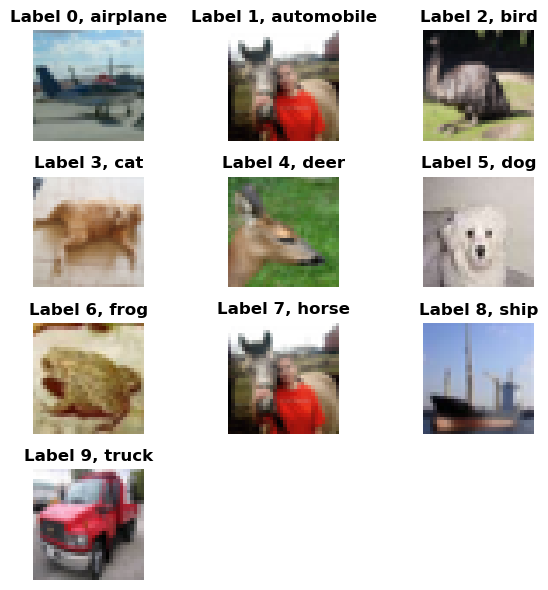

In [19]:
plt.figure(figsize=(6, 6))

for i in range(10):
  ax = plt.subplot(4, 3, i + 1)
  label_idx = tf.argmax(labels_batch.numpy() == i).numpy()
  plt.imshow(image_batch[label_idx])
  plt.title(f"Label {i}, {[objct for objct, value in object_mapping.items() if value ==i][0]}", fontweight="bold")
  plt.axis("off")

plt.tight_layout()


# Building a CNN with Sequential API, later StratifiedKFold

In [20]:
# input=W, filter=F, padding=P, S=Stride, => (W−F+2P)/S+1

In [21]:
model = tf.keras.Sequential([

    tf.keras.layers.InputLayer(input_shape=(32, 32, 3)),

    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(128, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Dropout(0.3),


    # Flatten and Dense
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

In [22]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                         factor=0.5, 
                                         patience=5, 
                                         min_lr=0.00001),
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                     patience=5, 
                                     restore_best_weights=True)
]

history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
1250/1250 [==============================] - 31s 21ms/step - loss: 1.8281 - accuracy: 0.3366 - val_loss: 1.6424 - val_accuracy: 0.4201 - lr: 0.0010
Epoch 2/50
1250/1250 [==============================] - 22s 18ms/step - loss: 1.4211 - accuracy: 0.4878 - val_loss: 1.2033 - val_accuracy: 0.5691 - lr: 0.0010
Epoch 3/50
1250/1250 [==============================] - 24s 19ms/step - loss: 1.2369 - accuracy: 0.5656 - val_loss: 0.9307 - val_accuracy: 0.6690 - lr: 0.0010
Epoch 4/50
1250/1250 [==============================] - 22s 17ms/step - loss: 1.0962 - accuracy: 0.6182 - val_loss: 0.9680 - val_accuracy: 0.6653 - lr: 0.0010
Epoch 5/50
1250/1250 [==============================] - 24s 19ms/step - loss: 0.9983 - accuracy: 0.6561 - val_loss: 0.9408 - val_accuracy: 0.6783 - lr: 0.0010
Epoch 6/50
1250/1250 [==============================] - 23s 18ms/step - loss: 0.9163 - accuracy: 0.6859 - val_loss: 0.7438 - val_accuracy: 0.7368 - lr: 0.0010
Epoch 7/50
1250/1250 [========================

In [24]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                      

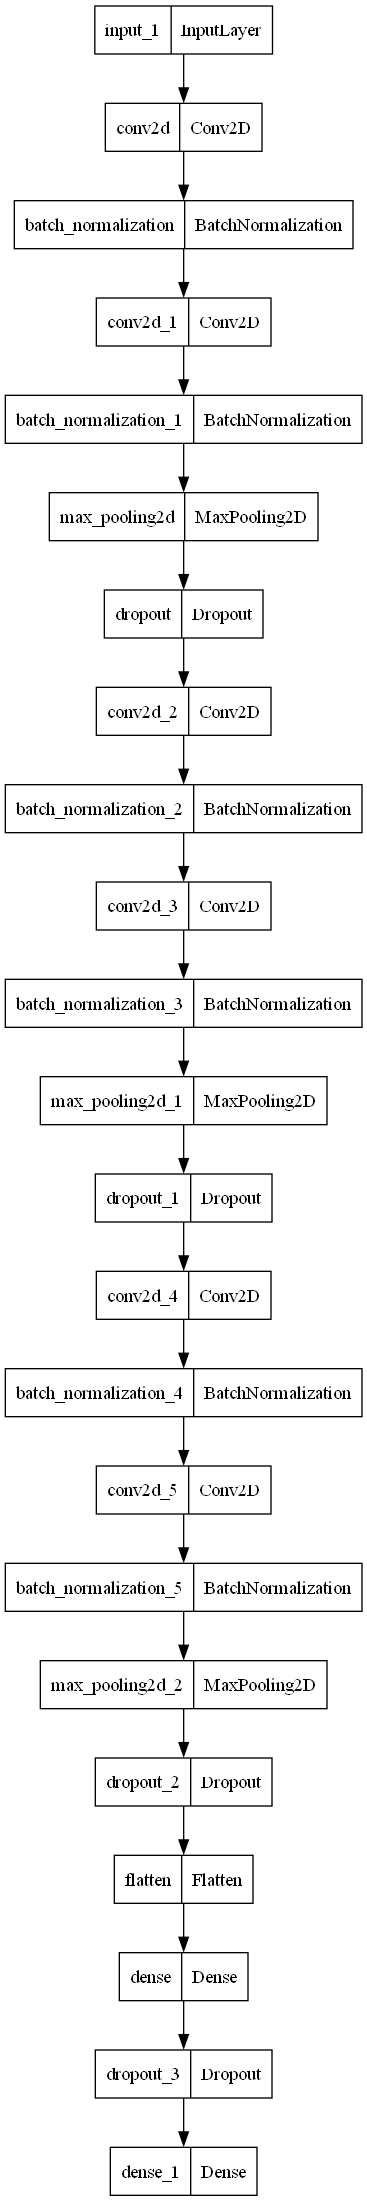

In [25]:
tf.keras.utils.plot_model(model)

In [26]:
def visualize_filter_responses(model, layer_index, input_image, nrows=int, ncols=int, figsize=(10, 6)):
    intermediate_model = tf.keras.Model(
        inputs=model.input, 
        outputs=model.layers[layer_index].output
    )
    
    responses = intermediate_model.predict(tf.expand_dims(input_image, 0))
    
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    for i in range(min(64, responses.shape[-1])):
        row = i // 8
        col = i % 8
        axs[row, col].set_title(f"Filter:{i}")
        axs[row, col].imshow(responses[0, :, :, i], cmap='viridis')
        axs[row, col].axis('off')
        
    plt.suptitle(f"Convolution layer indexed: {layer_index} applied on a sample image")
    plt.tight_layout()
    plt.show()

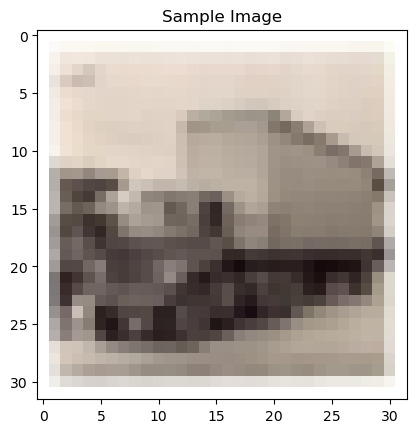

In [27]:
sample_image = next(iter(train_dataset))[0][0]
plt.title("Sample Image")
plt.imshow(sample_image)
plt.show()

1/1 [==============================] - 0s 254ms/step


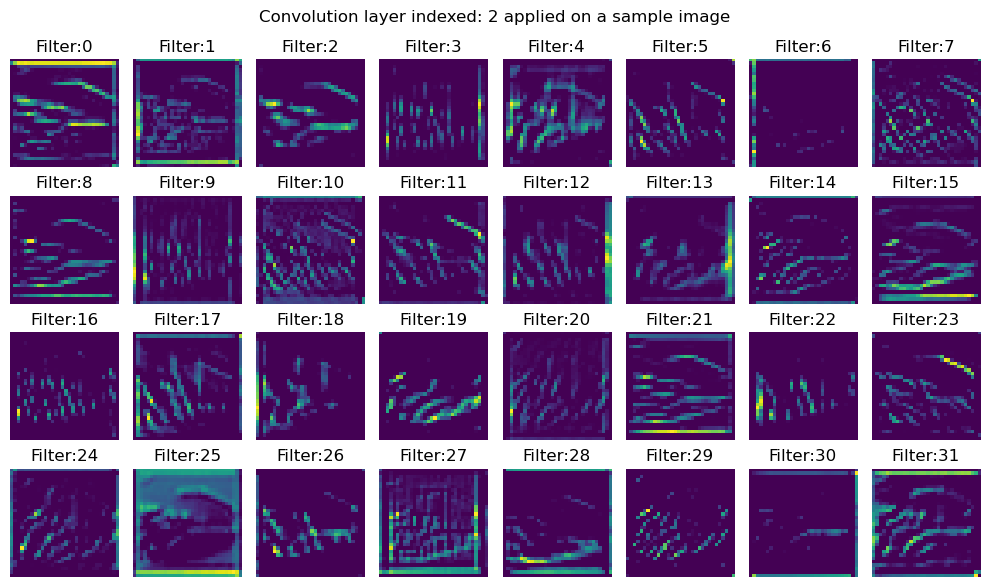

In [28]:
visualize_filter_responses(model, 2, sample_image, nrows=4, ncols=8)

1/1 [==============================] - 0s 215ms/step


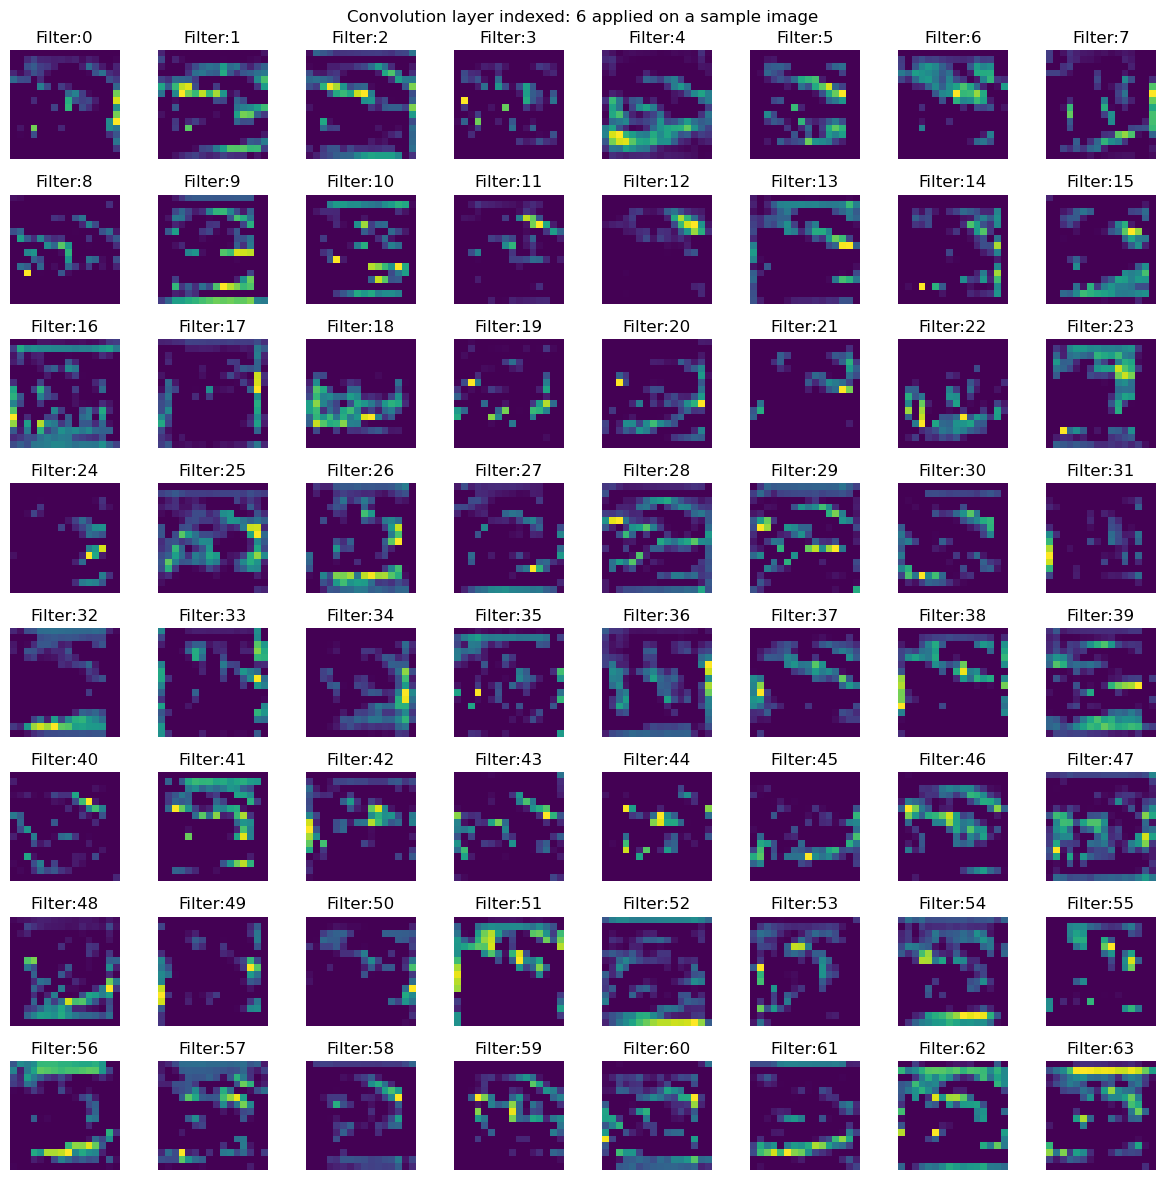

In [29]:
visualize_filter_responses(model, 6, sample_image, nrows=8, ncols=8, figsize=(12, 12))

In [30]:
predictions = model.predict(val_dataset)

313/313 [==============================] - 2s 5ms/step


In [31]:
predicted_labels = tf.argmax(predictions, axis=1)
predicted_labels = tf.cast(predicted_labels, tf.float16)
prediction_confidence = tf.reduce_max(predictions, axis=1)

In [32]:
validation_imgs = []
actual_labels = []
for imgs, labels in val_dataset:
    validation_imgs.extend(imgs.numpy())
    actual_labels.extend(labels.numpy())

validation_imgs = tf.convert_to_tensor(validation_imgs)
actual_labels = tf.convert_to_tensor(actual_labels)

In [33]:
cm = confusion_matrix(actual_labels, predicted_labels)
accuracy = accuracy_score(actual_labels, predicted_labels)

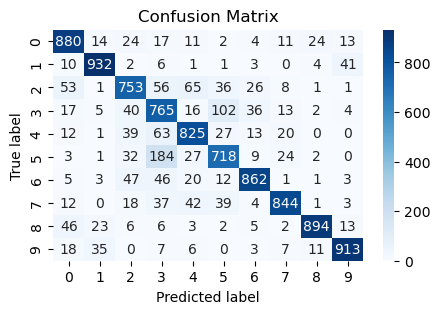

Validation Accuracy: 0.8386


In [34]:
plt.figure(figsize=(5, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

print(f"Validation Accuracy: {accuracy:.4f}")

In [35]:
precision = cm.diagonal() / cm.sum(axis=0)
recall = cm.diagonal() / cm.sum(axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)
output_nodes = 10

for i in range(output_nodes):
    print(f"Class {i}:")
    print(f"  Precision: {precision[i]:.4f}")
    print(f"  Recall: {recall[i]:.4f}")
    print(f"  F1-score: {f1_score[i]:.4f}")

print(f"\nMacro-average F1-score: {np.mean(f1_score):.4f}")

Class 0:
  Precision: 0.8333
  Recall: 0.8800
  F1-score: 0.8560
Class 1:
  Precision: 0.9182
  Recall: 0.9320
  F1-score: 0.9251
Class 2:
  Precision: 0.7836
  Recall: 0.7530
  F1-score: 0.7680
Class 3:
  Precision: 0.6445
  Recall: 0.7650
  F1-score: 0.6996
Class 4:
  Precision: 0.8120
  Recall: 0.8250
  F1-score: 0.8185
Class 5:
  Precision: 0.7646
  Recall: 0.7180
  F1-score: 0.7406
Class 6:
  Precision: 0.8933
  Recall: 0.8620
  F1-score: 0.8774
Class 7:
  Precision: 0.9075
  Recall: 0.8440
  F1-score: 0.8746
Class 8:
  Precision: 0.9511
  Recall: 0.8940
  F1-score: 0.9216
Class 9:
  Precision: 0.9213
  Recall: 0.9130
  F1-score: 0.9171

Macro-average F1-score: 0.8398


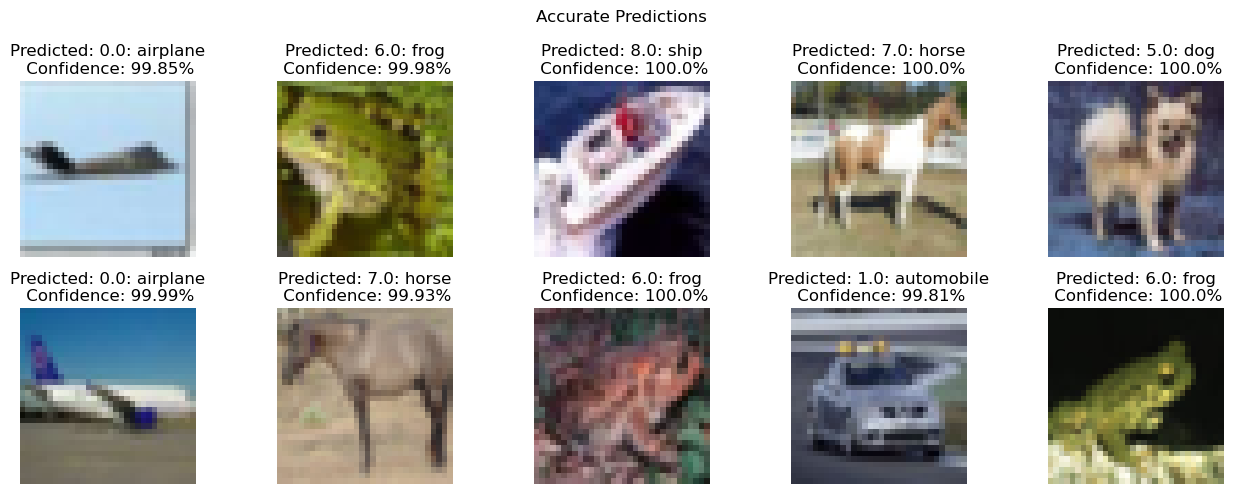

In [36]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(13, 5))
plt.suptitle("Accurate Predictions")

for i, ax in enumerate(axes.flat):
    random_index = np.random.choice(np.where(predicted_labels==actual_labels)[0])
    image = validation_imgs[random_index]
    fig = plt.figure
    ax.set_title(f"Predicted: {predicted_labels[random_index].numpy()}: {unique_labels[int(predicted_labels[random_index].numpy())].numpy().decode('utf8')}\n Confidence: {round(prediction_confidence[random_index].numpy()*100, 2)}%")
    ax.imshow(image)
    ax.set_axis_off()

plt.tight_layout()
plt.show()

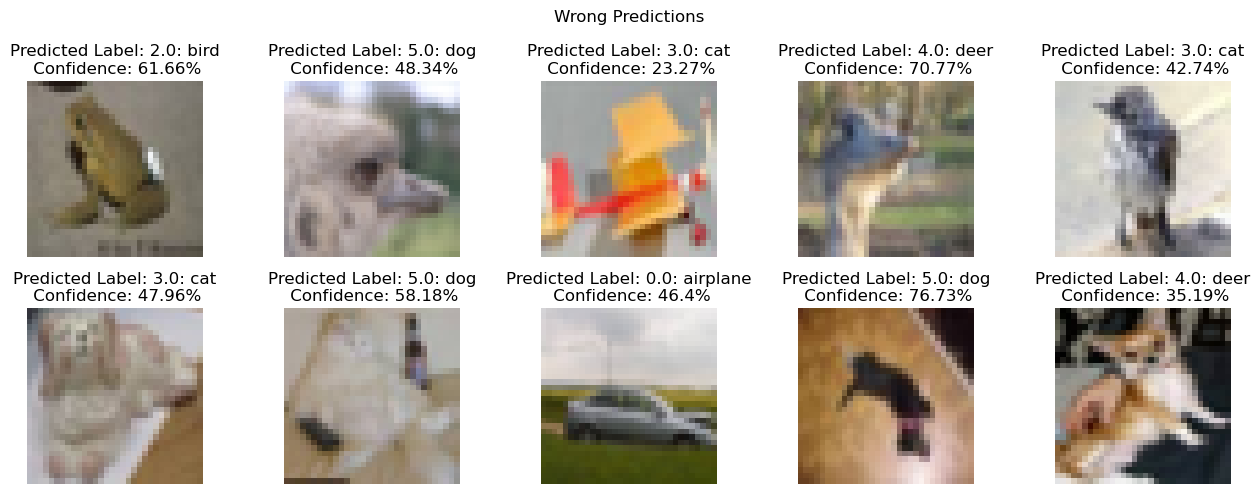

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(13, 5))
plt.suptitle("Wrong Predictions")

for i, ax in enumerate(axes.flat):
    random_index = np.random.choice(np.where(predicted_labels!=actual_labels)[0])
    image = validation_imgs[random_index]
    fig = plt.figure
    ax.set_title(f"Predicted Label: {predicted_labels[random_index].numpy()}: {unique_labels[int(predicted_labels[random_index].numpy())].numpy().decode('utf8')}\n Confidence: {round(prediction_confidence[random_index].numpy()*100, 2)}%")
    ax.imshow(image)
    ax.set_axis_off()

plt.tight_layout()
plt.show()

## Cross Validation on 5 Stratified KFold

In [55]:
# Just for reproducibility purpose
random_splits_seeds = [10, 555, 321, 5623113, 1244]

In [56]:
accuracies = []
for random_state in random_splits_seeds:

    train_ids, val_ids, train_labels, val_labels = train_test_split(labels_df["id"], labels_df["label"], test_size=0.2, stratify=labels_df["label"], random_state=random_state)
    val_ids = val_ids.values
    
    val_dataset = tf.data.Dataset.from_tensor_slices(val_ids)
    val_dataset = val_dataset.map(lambda id: load_image(id), 
                        num_parallel_calls=tf.data.AUTOTUNE)
    
    val_dataset = configure_performance(val_dataset, is_train_ds=False)
    predictions = model.predict(val_dataset)

    predicted_labels = tf.argmax(predictions, axis=1)
    predicted_labels = tf.cast(predicted_labels, tf.float16)

    actual_labels = []

    for _, labels in val_dataset:
        actual_labels.extend(labels.numpy())

    actual_labels = tf.convert_to_tensor(actual_labels)
    accuracy = accuracy_score(actual_labels, predicted_labels)
    print(f"Current Fold Accuracy: {round(accuracy, 4)}")
    accuracies.append(accuracy)    
    del val_dataset


313/313 [==============================] - 5s 14ms/step
Current Fold Accuracy: 0.9217
313/313 [==============================] - 4s 11ms/step
Current Fold Accuracy: 0.9245
313/313 [==============================] - 3s 10ms/step
Current Fold Accuracy: 0.9236
313/313 [==============================] - 3s 11ms/step
Current Fold Accuracy: 0.929
313/313 [==============================] - 4s 11ms/step
Current Fold Accuracy: 0.9244


In [57]:
print(f"5 Fold avg. accuracy: {round(np.mean(accuracies)*100, 2)}%")

5 Fold avg. accuracy: 92.46%


## Predict on test set

In [61]:
image_dir = r"datasets/test"

In [62]:
@tf.function
def load_image_test(id):
    id_str = tf.strings.as_string(id)
    image_path = tf.strings.join([image_dir, '/', id_str, '.png'])
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
        
    return image

In [63]:
test_ids = np.arange(1, 300001)

In [64]:
test_dataset = tf.data.Dataset.from_tensor_slices(test_ids)
test_dataset = test_dataset.map(lambda id: load_image_test(id), 
                        num_parallel_calls=tf.data.AUTOTUNE)

In [65]:
test_dataset = configure_performance(test_dataset, is_train_ds=False)

In [66]:
image_batch = next(iter(test_dataset))

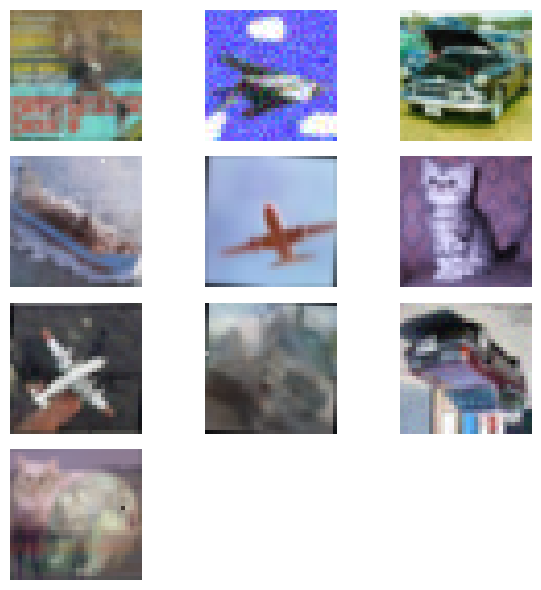

In [67]:
plt.figure(figsize=(6, 6))

for i in range(10):
  ax = plt.subplot(4, 3, i + 1)
  plt.imshow(image_batch[i])
  plt.axis("off")

plt.tight_layout()


In [68]:
predictions = model.predict(test_dataset)

9375/9375 [==============================] - 1025s 109ms/step


In [69]:
predicted_labels = tf.argmax(predictions, axis=1)
predicted_labels = tf.cast(predicted_labels, tf.int32)

In [70]:
submission = pd.DataFrame(np.arange(1, 300001), columns=["id"])
submission["label"] = predicted_labels.numpy()

In [88]:
submission.replace({"label": dict(zip(object_mapping.values(), object_mapping.keys()))}, inplace=True)

In [90]:
submission.to_csv("submission.csv", index=False)

## Using a State-of-Art CNN Architecture

https://arxiv.org/pdf/2201.03545

https://ar5iv.labs.arxiv.org/html/2301.00808